In [253]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import scipy.stats as st

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [2]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

In [19]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [2.07e-4, 0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [3.1e-4,0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}
filt_use = ['GALEX_FUV','GALEX_NUV','CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']


In [126]:
hdul = fits.open('/Users/colinburke/research/dwarf_agn_cosmos/cigale/mock/out/models-block-0.fits')
mock_results = hdul[1].data
central_wavelengths = np.array([filt_dict[k][0] for k in filt_use])*1e-4 # um
print(central_wavelengths)
print(mock_results.names)

[0.1526 0.2307 0.3709 0.3858 0.4847 0.6219 0.7699 0.8894 0.9761 1.0216
 1.2525 1.6466 0.9063 3.5686 4.5067 5.7788]
['id', 'g_prime', 'i_prime', 'r_prime', 'u_prime', 'vista.vircam.H', 'vista.vircam.J', 'vista.vircam.Ks', 'z_prime', 'agn.L_6um', 'agn.accretion_power', 'agn.disk_luminosity', 'agn.intrin_Lnu_2500A_30deg', 'agn.luminosity', 'agn.polar_dust_luminosity', 'agn.torus_dust_luminosity', 'agn.total_dust_luminosity', 'dust.luminosity', 'dust.mass', 'sfh.integrated', 'sfh.sfr', 'sfh.sfr100Myrs', 'sfh.sfr10Myrs', 'stellar.lum', 'stellar.lum_ly', 'stellar.lum_ly_old', 'stellar.lum_ly_young', 'stellar.lum_old', 'stellar.lum_young', 'stellar.m_gas', 'stellar.m_gas_old', 'stellar.m_gas_young', 'stellar.m_star', 'stellar.m_star_old', 'stellar.m_star_young', 'stellar.n_ly', 'stellar.n_ly_old', 'stellar.n_ly_young', 'agn.EBV', 'agn.Mcl', 'agn.R', 'agn.delta', 'agn.disk_type', 'agn.emissivity', 'agn.fracAGN', 'agn.i', 'agn.law', 'agn.oa', 'agn.pl', 'agn.q', 'agn.t', 'agn.temperature', 'atte

### Convert simulated photometry to new cigale input file

In [186]:
bands = ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']
data_phot = []

hdul = fits.open('/Users/colinburke/research/dwarf_agn_cosmos/cigale/mock/out/models-block-0.fits')
mock_results = hdul[1].data

data_phot.append(list(range(len(mock_results))))
data_phot.append(np.full(len(mock_results), 0.0))

for b in bands:
    data_phot.append(np.random.normal(mock_results[b], 0.1*mock_results[b])) # randomly sample 10% errors
    
data_phot = np.array(data_phot)
fmt = '%d ' + ' '.join(['%0.8f']*(len(bands) + 1))

hdr = 'id redshift '+' '.join(bands)

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt('mock_analysis/phot.dat', data_phot.T, header=hdr, fmt=fmt)
# g_prime, i_prime, r_prime, u_prime, vista.vircam.H, vista.vircam.J, vista.vircam.Ks, z_prime

hdr: 1


``cd ./mock_analysis/float``

``pcigale run``

``cd ./mock_analysis/f_agn1``

``pcigale run``

### Mock analysis

TODO? Does not includes errors, which will affect the chi2!

In [197]:
# Convert the mock results to a new CIGALE input file

# Plot err. in stellar mass vs. AGN fraction and dChi^2

# Plot output
hdul = fits.open('./mock_analysis/float/out/results.fits')
results_float = hdul[1].data

hdul = fits.open('./mock_analysis/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

In [198]:
print(results_float.names)

['id', 'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'bayes.g_prime', 'bayes.g_prime_err', 'bayes.i_prime', 'bayes.i_prime_err', 'bayes.r_prime', 'bayes.r_prime_err', 'bayes.u_prime', 'bayes.u_prime_err', 'bayes.vista.vircam.H', 'bayes.vista.vircam.H_err', 'bayes.vista.vircam.J', 'bayes.vista.vircam.J_err', 'bayes.vista.vircam.Ks', 'bayes.vista.vircam.Ks_err', 'bayes.z_prime', 'bayes.z_prime_err', 'best.chi_square', 'best.reduced_chi_square', 'best.agn.EBV', 'best.agn.Mcl', 'best.agn.R', 'best.agn.delta', 'best.agn.disk_type', 'best.agn.emissivity', 'best.agn.fracAGN', 'best.agn.i', 'best.agn.law', 'best.agn.oa', 'best.agn.pl', 'best.agn.q', 'best.agn.t', 'best.agn.temperature', 'best.attenuation.B_B90', 'best.attenuation.E_BV_factor', 'best.attenuation.E_BV_lines', 'best.attenuation.E_BVs', 'best.attenuation.FUV', 'best.attenuation.V_B90', 'best.attenuation.powerlaw_slope', 'best.attenuation.uv_bump_amplitude', 'best.attenuation.uv_bump_wavelength', 'best.attenuation.uv_bump_wid

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5.5, 6.5))

fagn1 = axs[0].scatter(dchi2[agn_i_in==30], dlog_m_star[agn_i_in==30], marker='.', alpha=0.25, c=f_agn_in[agn_i_in==30]) # type 1
fagn2 = axs[1].scatter(dchi2[agn_i_in==70], dlog_m_star[agn_i_in==70], marker='.', alpha=0.25, c=f_agn_in[agn_i_in==70]) # type 2


0.24476809049864617
0.8178797572448259


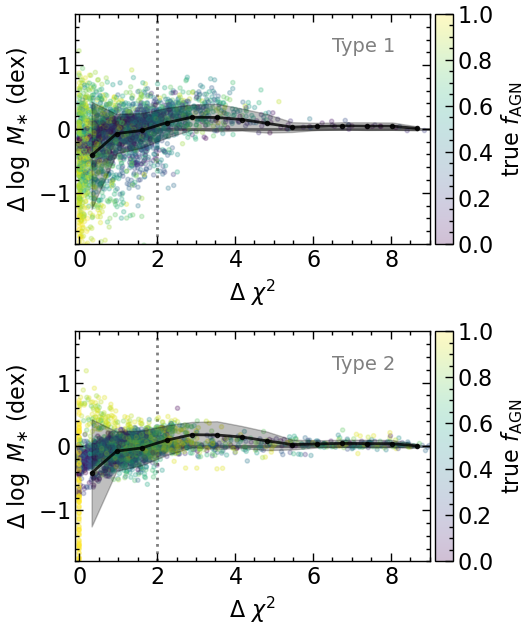

In [286]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f_agn_in = mock_results['agn.fracAGN']
f_agn_in[f_agn_in==0.9999] = 1
#f_agn_in = results_float['best.agn.fracAGN']

agn_i_in = mock_results['agn.i']

#agn_i_in = results_float['best.agn.i']


dlog_m_star = np.log10(mock_results['stellar.m_star'])-np.log10(results_float['bayes.stellar.m_star'])

dchi2 = results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']


#fig, ax = plt.subplots(1,1, figsize=(5.5, 4.5))

#ax.scatter(f_agn_in[agn_i_in<45], (m_star_in-m_star_out)[agn_i_in<45]) # type 1
#ax.scatter(f_agn_in[agn_i_in>45], (m_star_in-m_star_out)[agn_i_in>45], color='r') # type 2

#ax.set_ylim(-1, 1)

#ax.set_ylabel(r'$\Delta\ M_{\ast}$ (dex)')
#ax.set_xlabel(r'true $f_{\rm AGN}$')


fig, axs = plt.subplots(2,1, figsize=(5.5, 6.5))

fagn1 = axs[0].scatter(dchi2[agn_i_in==30], dlog_m_star[agn_i_in==30], marker='.', alpha=0.25, c=f_agn_in[agn_i_in==30]) # type 1
fagn2 = axs[1].scatter(dchi2[agn_i_in==70], dlog_m_star[agn_i_in==70], marker='.', alpha=0.25, c=f_agn_in[agn_i_in==70]) # type 2

print(np.std(dlog_m_star[(agn_i_in==30) & (dchi2>2)]))
print(np.std(dlog_m_star[(agn_i_in==30) & (dchi2<2)]))


for i, axi in enumerate(axs):
    
    # 
    mean, bin_edges, _ = st.binned_statistic(dchi2, dlog_m_star, statistic='mean', bins=14, range=[0, 9])
    std, bin_edges, _ = st.binned_statistic(dchi2, dlog_m_star, statistic='std', bins=14, range=[0, 9])

    axi.plot(bin_edges[:-1] + np.diff(bin_edges)[0]/2, mean, marker='.', alpha=0.8, color='k')
    axi.fill_between(bin_edges[:-1] + np.diff(bin_edges)[0]/2, mean+std, mean-std, alpha=0.25, color='k')

    axi.axhline(0, 0, 1, color='gray', zorder=-1)
    axi.axvline(2, 0, 1, color='gray', zorder=-1, linestyle='dotted')
    
    # Ax

    axi.set_xlim(-0.1, 9)
    axi.set_ylim(-1.8, 1.8)

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(np.array([fagn1, fagn2])[i], cax=cax)
    cax.set_ylabel(r'true $f_{\rm AGN}$')

    axi.set_ylabel(r'$\Delta\ \log\ M_{\ast}$ (dex)')
    axi.set_xlabel(r'$\Delta\ \chi^2$')
    
    axi.text(6.5, 1.2, f'Type {np.array([1,2])[i]}', fontsize=14, color='gray')

fig.tight_layout()
fig.savefig('m_star_mock.pdf', dpi=300)

In [283]:
# Repeat with adding Galex and X-ray data (gives you an idea of redshift)
# Should be relatively insensitive to bands as long as
# Adding IRAC can help AGN/dust emission, which is energetically conserved, can help inform other parts of the SED.
# UV can constrain help constrain AGN UV part

In [ ]:
# this dchi2 is sensitive to error bars right?

(array([1219., 3543.,  791.,  106.,  107.,  138.,    0.,    0.,    4.,
         140.]),
 array([-1.70855613, -0.01785957,  1.672837  ,  3.36353356,  5.05423013,
         6.74492669,  8.43562326, 10.12631982, 11.81701638, 13.50771295,
        15.19840951]),
 <BarContainer object of 10 artists>)

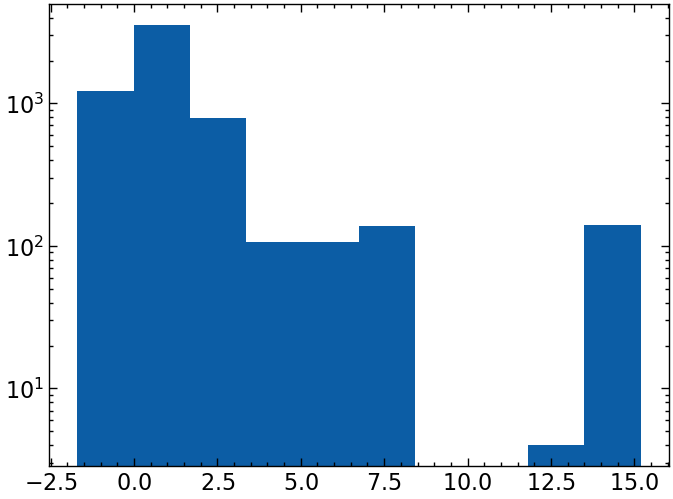

In [192]:
plt.hist(dchi2, log=True)

(array([5.225e+03, 7.500e+02, 5.200e+01, 1.200e+01, 4.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.00705577, 0.63772861, 1.26840146, 1.8990743 , 2.52974715,
        3.16042   , 3.79109284, 4.42176569, 5.05243853, 5.68311138,
        6.31378422]),
 <BarContainer object of 10 artists>)

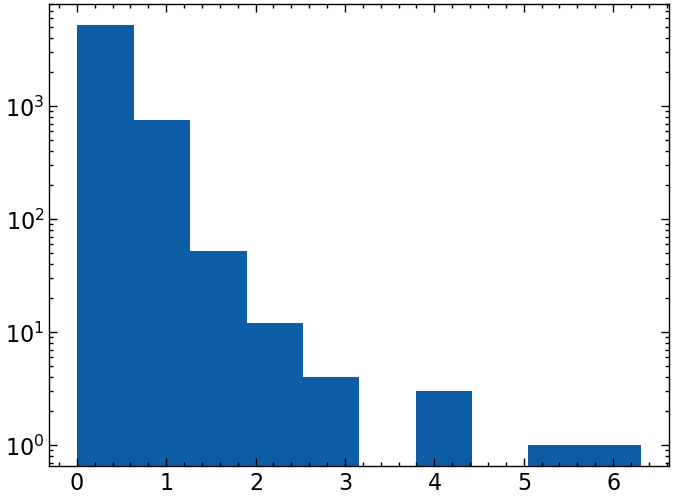

In [195]:
plt.hist(results_float['best.reduced_chi_square'], log=True)
#plt.hist(results_float['best.reduced_chi_square'], log=True)